In [ ]:
import os
import pandas

### Construccion de Dataset

Comenzamos por agrupar imagenes en carpetas por clase

In [35]:
import os
import shutil

# Ruta de la carpeta con las imágenes
carpeta_imagenes = '..\data\prepared_data\\raw_images'

# Crear una carpeta para cada clase y mover las imágenes
for nombre_archivo in os.listdir(carpeta_imagenes):
    # Ignorar archivos que no sean imágenes (opcional)
    if not nombre_archivo.endswith(('.jpg', '.jpeg', '.png')):
        continue

    # Extraer la clase del nombre del archivo (todo antes del último guion bajo)
    clase = '_'.join(nombre_archivo.split('_')[:-2])

    # Ruta de la carpeta de clase
    carpeta_clase = os.path.join(carpeta_imagenes, clase)

    # Crear la carpeta si no existe
    if not os.path.exists(carpeta_clase):
        os.makedirs(carpeta_clase)

    # Mover el archivo a la carpeta correspondiente
    origen = os.path.join(carpeta_imagenes, nombre_archivo)
    destino = os.path.join(carpeta_clase, nombre_archivo)
    shutil.move(origen, destino)

print("Imágenes organizadas en carpetas según su clase.")

Imágenes organizadas en carpetas según su clase.


Del total de clases posibles, nos quedamos solo con 40. Esto porque muchos tipos de pastillas son muy similares entre si y esto hace que no sean utiles para el entrenamiento. 

In [3]:
total = 0
for folder in os.listdir("..\data\prepared_data\selected_classes"):
    total += len(os.listdir(f"..\data\prepared_data\selected_classes\{folder}")) 

total

1136

Asi nos queda un total de 1136 imagenes

Separamos estas imagenes en train, test y validation.

In [5]:
import splitfolders

# Ruta al dataset original
input_folder = "..\data\prepared_data\selected_classes"

# Ruta donde se almacenarán los conjuntos separados
output_folder = "..\data\prepared_data\selected_split_data"

# Dividir en train (80%), validation (10%) y test (10%)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None)


En base a estos datos, disenamos la clase Dataset de Pytorch, la cual usa las clases para generar pares de imagenes negativos y positivos. Se le puede configurar la cantidad de pares que se generan con cada imagen usando los parametros max_positive_combinations y max_negative_combinations.

In [43]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class SiameseDataset(Dataset):

    """
    Clase para crear un dataset de siamesas que genera pares de imágenes
    etiquetadas como similares o diferentes.

    Esta clase permite generar combinaciones positivas y negativas de imágenes,
    garantizando que no se repitan pares (independientemente del orden) y
    limitando el número de veces que una imagen puede ser seleccionada.

    Args:
        image_folder (str): Ruta a la carpeta que contiene las imágenes organizadas por clase.
        transform (callable, optional): Transformaciones a aplicar a las imágenes.
        max_positive_combinations (int, optional): Número máximo de combinaciones positivas permitidas por imagen.
        max_negative_combinations (int, optional): Número máximo de combinaciones negativas permitidas por imagen.

    Attributes:
        pairs (list): Lista de pares de imágenes generadas.
        generated_pairs (set): Conjunto para almacenar pares ya generados (sin importar el orden).
    """

    def __init__(self, image_folder, transform=None, max_positive_combinations=5, max_negative_combinations=5, seed=42):
        self.image_folder = image_folder
        self.transform = transform

        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)
        
        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToTensor()        
            ])
        self.classes = os.listdir(image_folder)
        self.class_dict = {class_name: os.listdir(os.path.join(image_folder, class_name)) for class_name in self.classes}

        # Conjunto para almacenar combinaciones ya utilizadas (sin importar el orden)
        self.generated_pairs = set()

        # Generar todas las combinaciones posibles
        self.pairs = []
        self.generate_combinations(max_positive_combinations, max_negative_combinations)

    def _add_pair(self, img1, img2, label, class_name1, class_name2):
        """
        Añade un par al dataset si no ha sido generado previamente.
        """
        pair_key = frozenset([img1, img2])  # Usamos frozenset para evitar repetición sin importar el orden
        if pair_key not in self.generated_pairs:
            self.generated_pairs.add(pair_key)
            self.pairs.append((img1, img2, class_name1, class_name2, label))

    def generate_combinations(self, max_positive_combinations, max_negative_combinations):
        """
        Genera todas las combinaciones de pares de imágenes, respetando los límites
        de combinaciones positivas y negativas, evitando duplicados por imagen.
        """
        # Generar combinaciones positivas (máx. max_positive_combinations por imagen)
        for class_name, images in self.class_dict.items():
            num_images = len(images)
            for img1 in images:
                # Calcular la cantidad máxima posible de combinaciones positivas para esta imagen
                max_possible_combinations = min(max_positive_combinations, num_images - 1)
                positive_count = 0  # Contador para limitar combinaciones por imagen
                # Generar combinaciones positivas mientras haya posibilidades
                while positive_count < max_possible_combinations:
                    img2 = random.choice(images)
                    if img1 != img2:  # Evitar pares con la misma imagen
                        self._add_pair(img1, img2, 1, class_name, class_name)  # Etiqueta 1 = Positiva
                        positive_count += 1
        
        # Generar combinaciones negativas (máx. max_negative_combinations por imagen)
        for class_name1, images1 in self.class_dict.items():
            for img1 in images1:
                negative_count = 0  # Contador para limitar combinaciones por imagen
                while negative_count < max_negative_combinations:
                    # Seleccionar una clase diferente para generar el par negativo
                    class_name2 = random.choice([c for c in self.classes if c != class_name1])
                    img2 = random.choice(self.class_dict[class_name2])
                    self._add_pair(img1, img2, 0, class_name1, class_name2)  # Etiqueta 0 = Negativa
                    negative_count += 1

        random.shuffle(self.pairs)  # Mezclar los pares para asegurar la aleatoriedad

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # Obtener los pares pre-generados
        img1_name, img2_name, class_name1, class_name2, label = self.pairs[idx]
        
        img1_path = os.path.join(self.image_folder, class_name1, img1_name)
        img2_path = os.path.join(self.image_folder, class_name2, img2_name)

        img1 = Image.open(img1_path) 
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor([label], dtype=torch.float32)




Creamos train_dataset para hacer una prueba

In [49]:
from torch.utils.data import DataLoader


train_dataset = SiameseDataset(
    image_folder="..\data\prepared_data\selected_split_data\\train",
    transform=None,
    max_positive_combinations=10,
    max_negative_combinations=10
)

len(train_dataset)

14689

Usando max_positive_combinations=10 y max_negative_combinations=10, nos queda un dataset de entrenamiento de 14689 combinaciones posibles.

### EDA

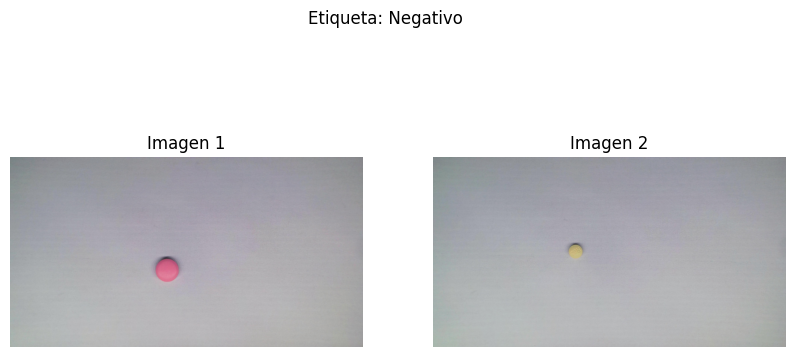

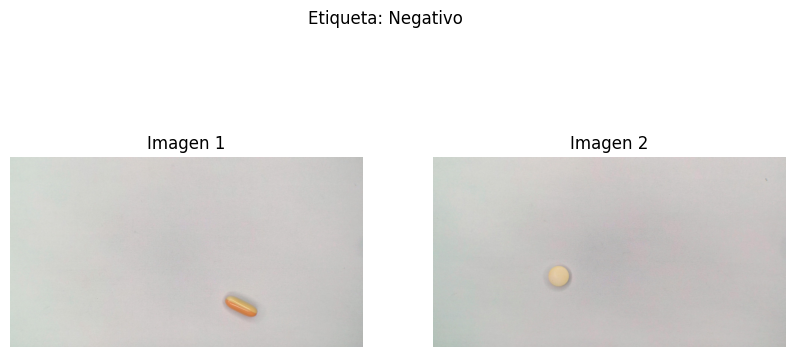

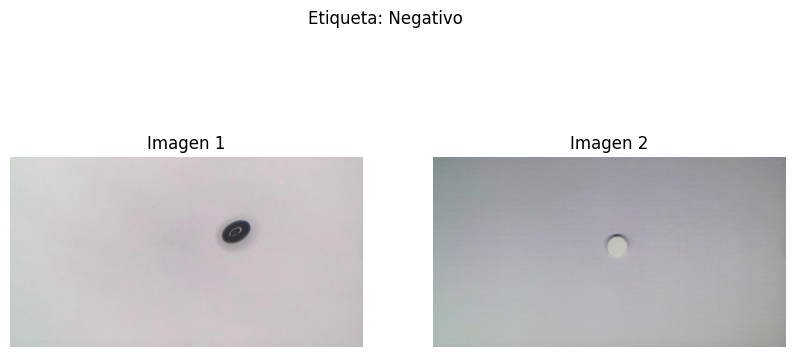

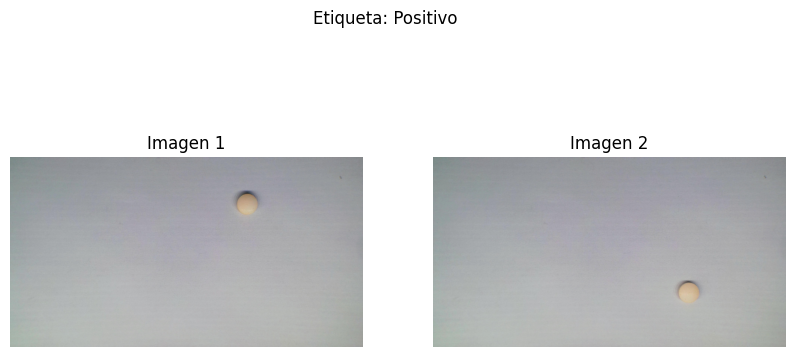

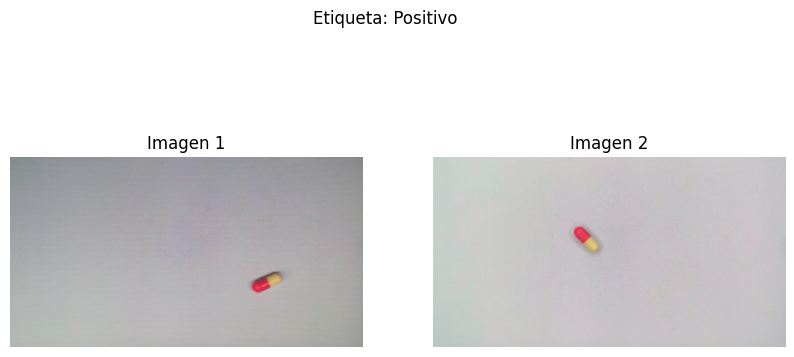

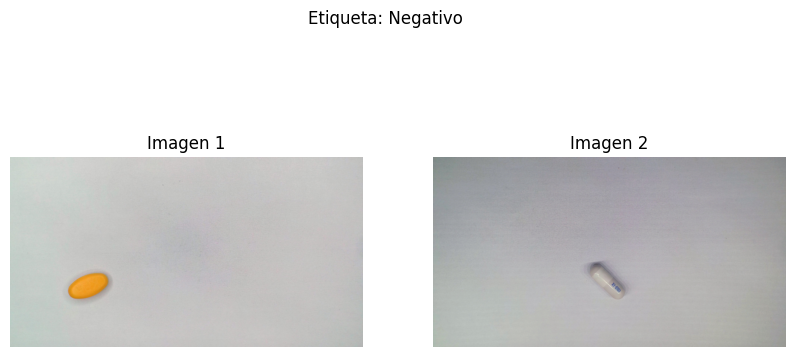

In [53]:
import matplotlib.pyplot as plt
import random

def show_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    img1, img2, label = dataset[idx]
    img1 = img1.permute(1, 2, 0).numpy()
    img2 = img2.permute(1, 2, 0).numpy()
    

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].set_title("Imagen 1")

    axes[1].imshow(img2)
    axes[1].set_title("Imagen 2")

    plt.suptitle(f'Etiqueta: {"Positivo" if label.item() == 1 else "Negativo"}')

    for ax in axes:
        ax.axis('off')

    plt.show()

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)

